# Neural style transfer

## Introduction

Передача стиля заключается в создании изображения
с тем же "содержанием", что и базовое изображение, но со
"стилем" другого изображения (обычно художественного).
Это достигается за счет оптимизации функции потерь
, которая состоит из 3 компонентов: "style loss", "content loss"
и "total variation loss".:

- Полная потеря вариации создает локальную пространственную непрерывность между
пикселями комбинированного изображения, придавая ему визуальную согласованность.
- Потеря стиля - это то, где сохраняется глубокое обучение - оно определяется
с помощью глубокой сверточной нейронной сети. Точнее, она состоит в сумме
L2 расстояния между матрицами Грамм представлений
базового изображения и эталонного изображения стиля, извлеченных из
разных слоев convnet (обученных в ImageNet). Общая идея
состоит в том, чтобы захватить информацию о цвете / текстуре в разных пространственных
масштабах (довольно больших масштабах, определяемых глубиной рассматриваемого слоя).
- Потеря содержимого представляет собой расстояние L2 между объектами базового
изображения (извлеченного из глубокого слоя) и объектами комбинированного изображения,
сохраняя сгенерированное изображение достаточно близким к исходному.
**Reference:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)


## Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


950272/935806 [==============================] - 1s 1us/step


## Let's take a look at our base (content) image and our style reference image


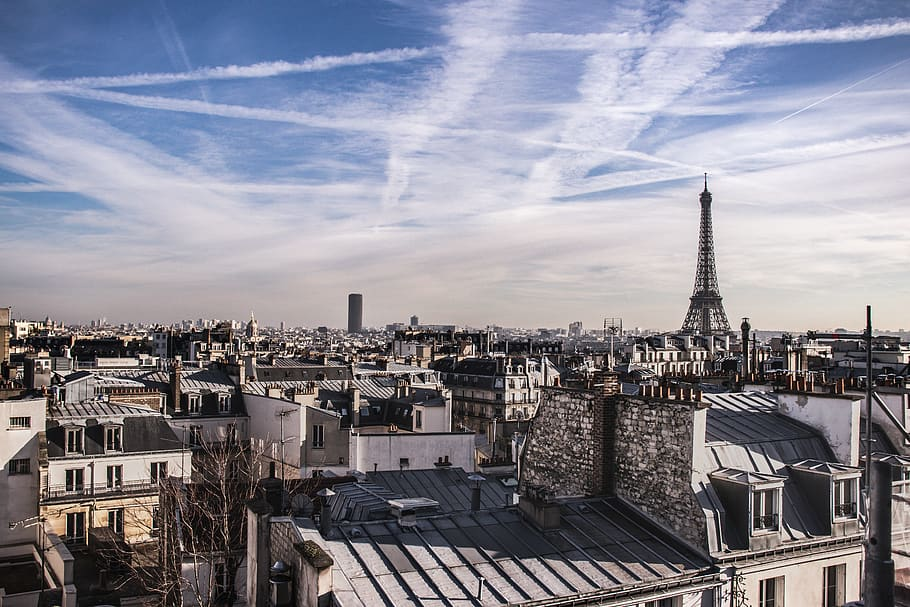

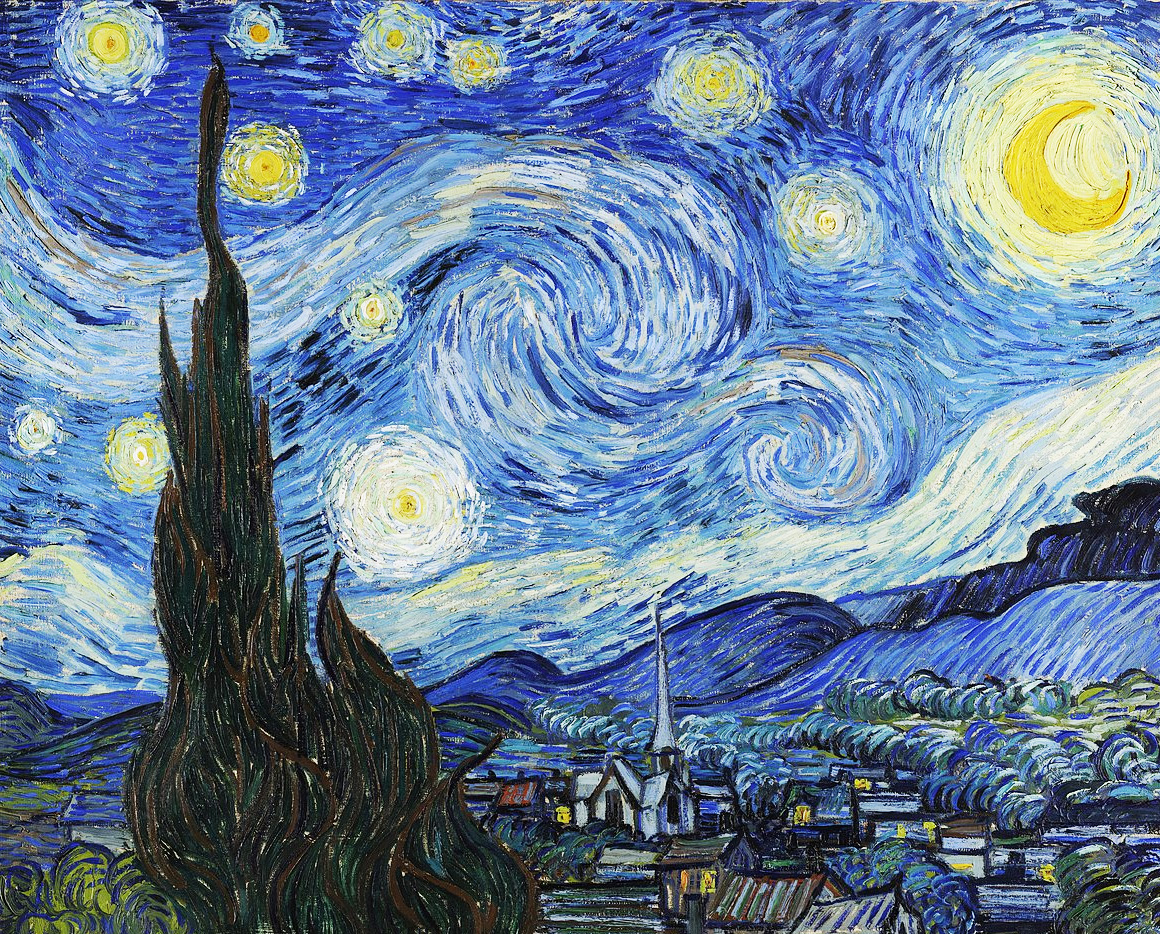

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))


## Image preprocessing / deprocessing utilities


In [ ]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



## Compute the style transfer loss

Во-первых, нам нужно определить 4 функции полезности:

- `gram_matrix` (используется для вычисления потери стиля)
- Функция style_loss, которая сохраняет сгенерированное изображение близким к локальным текстурам
эталонного изображения стиля.
- Функция `content_loss`, которая сохраняет высокоуровневое представление
сгенерированного изображения близким к представлению базового изображения
- Функция `total_variation_loss`, потеря регуляризации, которая сохраняет сгенерированное
изображение локально когерентным

In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# "style loss" предназначена для поддержания
# стиля эталонного изображения в сгенерированном изображении.
# Он основан на матрицах грама (которые фиксируют стиль)
# карты объектов из эталонного изображения стиля
# и из сгенерированного изображения


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# Вспомогательная функция потерь
# предназначена для поддержания "содержимого"
# базового изображения в сгенерированном изображении


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# 3-я функция потерь, полная потеря вариации,
# предназначена для поддержания локальной когерентности сгенерированного изображения.


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



Далее давайте создадим модель извлечения объектов, которая извлекает промежуточные активации
VGG 19 (в виде dict, по имени).

In [ ]:
# Создайте модель VGG19, загруженную предварительно обученными весами ImageNet
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Получите символические выходные данные каждого "ключевого" слоя (мы дали им уникальные имена).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Настройте модель, которая возвращает значения активации для каждого слоя в
# VGG 19 (как dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


80150528/80134624 [==============================] - 3s 0us/step


Наконец, вот код, который вычисляет потерю при передаче стиля.


In [ ]:
# Список слоев, которые будут использоваться для style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# Слой, который будет использоваться для content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss



## Добавьте декоратор tf.function для вычисления потерь и градиентов

Чтобы скомпилировать его и, таким образом, сделать его быстрым.


In [ ]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads



## The training loop

Многократно выполняйте шаги ванильного градиентного спуска, чтобы минимизировать потери, и сохраняйте
результирующее изображение каждые 100 итераций.

Мы уменьшаем скорость обучения на 0,96 каждые 100 шагов.


In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=11018.15
Iteration 200: loss=8514.06
Iteration 300: loss=7571.51
Iteration 400: loss=7063.93
Iteration 500: loss=6735.96
Iteration 600: loss=6501.45
Iteration 700: loss=6323.20
Iteration 800: loss=6181.49
Iteration 900: loss=6065.37
Iteration 1000: loss=5967.71
Iteration 1100: loss=5884.62
Iteration 1200: loss=5812.90
Iteration 1300: loss=5750.52
Iteration 1400: loss=5695.92
Iteration 1500: loss=5647.62
Iteration 1600: loss=5604.56
Iteration 1700: loss=5565.86
Iteration 1800: loss=5531.02
Iteration 1900: loss=5499.51
Iteration 2000: loss=5470.87
Iteration 2100: loss=5444.76
Iteration 2200: loss=5420.88
Iteration 2300: loss=5399.02
Iteration 2400: loss=5378.88
Iteration 2500: loss=5360.29
Iteration 2600: loss=5343.11
Iteration 2700: loss=5327.20
Iteration 2800: loss=5312.42
Iteration 2900: loss=5298.71
Iteration 3000: loss=5285.93
Iteration 3100: loss=5274.04
Iteration 3200: loss=5262.90
Iteration 3300: loss=5252.48
Iteration 3400: loss=5242.70
Iteration 3500: loss=5

После 4000 итераций вы получите следующий результат:


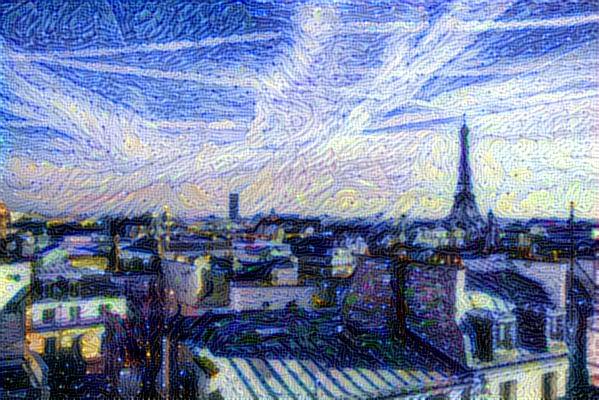

In [ ]:
display(Image(result_prefix + "_at_iteration_4000.png"))


In [ ]:
base_image_path_list = ['/content/117.jpg', '/content/rss-image-62.png']
style_reference_image_path_list = [keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"), '/content/LA03_01.jpg']
result_prefix_list = ["omsk_night_generated", "omsk_autumn_generated", "St_Peterburg_night_generated", "St_Peterburg_autumn_generated"]

In [ ]:
for i, base in enumerate(base_image_path_list):
  for j, style in enumerate(style_reference_image_path_list):
    base_image = preprocess_image(base)
    style_reference_image = preprocess_image(style)
    combination_image = tf.Variable(preprocess_image(base))

    iterations = 4000
    for k in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(
            combination_image, base_image, style_reference_image
        )
        optimizer.apply_gradients([(grads, combination_image)])
        if k % 100 == 0:
            print("Iteration %d: loss=%.2f" % (k, loss))
            img = deprocess_image(combination_image.numpy())
            fname = result_prefix_list[i*2+j] + "_at_iteration_%d.png" % k
            keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=23263.68
Iteration 200: loss=17870.79
Iteration 300: loss=15120.13
Iteration 400: loss=13425.77
Iteration 500: loss=12282.84
Iteration 600: loss=11462.30
Iteration 700: loss=10845.17
Iteration 800: loss=10364.76
Iteration 900: loss=9980.45
Iteration 1000: loss=9665.80
Iteration 1100: loss=9403.53
Iteration 1200: loss=9181.54
Iteration 1300: loss=8991.23
Iteration 1400: loss=8826.25
Iteration 1500: loss=8681.79
Iteration 1600: loss=8554.27
Iteration 1700: loss=8440.87
Iteration 1800: loss=8339.42
Iteration 1900: loss=8248.20
Iteration 2000: loss=8165.75
Iteration 2100: loss=8090.85
Iteration 2200: loss=8022.57
Iteration 2300: loss=7960.01
Iteration 2400: loss=7902.52
Iteration 2500: loss=7849.57
Iteration 2600: loss=7800.65
Iteration 2700: loss=7755.33
Iteration 2800: loss=7713.26
Iteration 2900: loss=7674.17
Iteration 3000: loss=7637.74
Iteration 3100: loss=7603.75
Iteration 3200: loss=7572.00
Iteration 3300: loss=7542.26
Iteration 3400: loss=7514.36
Iteration 3500:

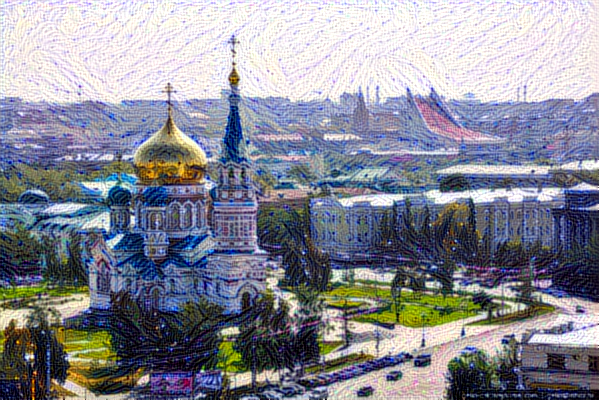

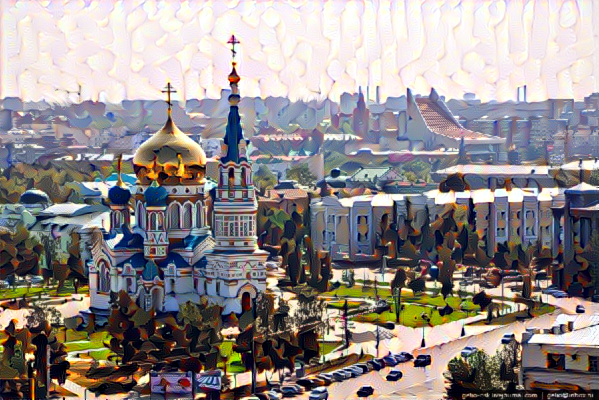

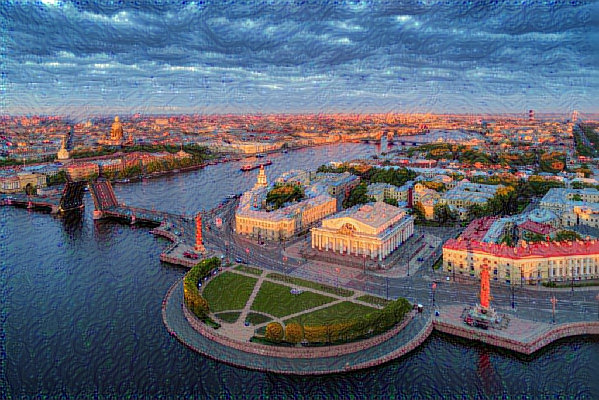

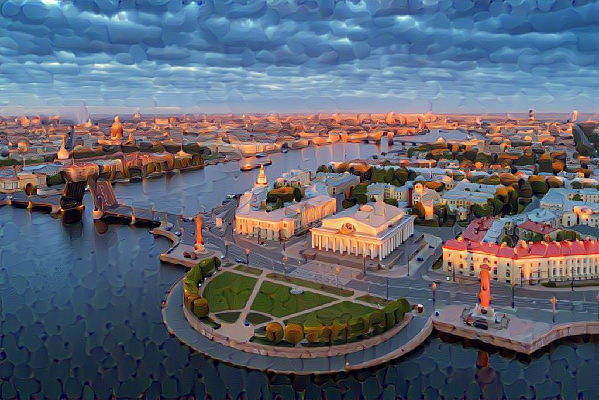

In [ ]:
for pref in result_prefix_list:
  display(Image(pref + "_at_iteration_4000.png"))